In [ ]:
import os
import random
import shutil

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
import timm
from thop import profile

import time
from datetime import timedelta

In [ ]:
# Set the seed for Python's random module
random.seed(17)

# Set the seed for NumPy
np.random.seed(17)

# Set the seed for PyTorch (CPU and CUDA)
torch.manual_seed(17)

# Ensure that CUDA operations are deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the seed for CUDA as well
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(17)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.cuda.current_device())  # Should print the index of the GPU being used

# Check the name of the GPU
print(torch.cuda.get_device_name(torch.cuda.current_device()))

0
NVIDIA GeForce RTX 4060 Laptop GPU


## Data Preparation

In [ ]:
len(os.listdir('data/train/MSS')), len(os.listdir('data/val/MSS')), len(os.listdir('data/test/MSS'))

(37505, 4600, 4600)

In [ ]:
len(os.listdir('data/train/MSI')), len(os.listdir('data/val/MSI')), len(os.listdir('data/test/MSI'))

(37505, 4600, 4600)

In [ ]:
# Define the transforms for data preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

In [ ]:
# Load the full dataset
train_data = datasets.ImageFolder(root='data/train', transform=transform)
val_data = datasets.ImageFolder(root='data/val', transform=transform)
test_data = datasets.ImageFolder(root='data/test', transform=transform)

In [ ]:
print(train_data.class_to_idx)

{'MSI': 0, 'MSS': 1}


In [ ]:
batch_size = 32

In [ ]:
# DataLoader for batch processing
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

## Functions

In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience = 3  # Number of epochs to wait for improvement
    epochs_without_improvement = 0

    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print("\n" + f"Epoch {epoch + 1}/{num_epochs}" + "\n" + "_" * 10)

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float()) # Squeeze output, labels to float

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track performance
            running_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int().squeeze()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time  # Calculate epoch duration

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%, Time: {timedelta(seconds=epoch_time)}")
        torch.cuda.empty_cache()

        # Evaluate on validation set after each epoch
        val_loss, val_accuracy = evaluate_val(model, val_loader)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        torch.cuda.empty_cache()

        # Record training loss and accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Evaluate on validation set and record metrics
        val_loss, val_accuracy = evaluate_val(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
          print("Early stopping triggered")
          break

    total_end_time = time.time()  # Record end time of the entire training process
    total_time = total_end_time - total_start_time  # Calculate total training duration
    print(f"Training completed in {timedelta(seconds= total_time)}")

    # Plot the metrics
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to evaluate the model on the validation set
def evaluate_val(model, val_loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float()) #outputs, labels
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int().squeeze()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
# Function to evaluate the model
def evaluate_test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            predicted = (probs > 0.5).int().squeeze()  # Predictions based on probability threshold

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

    return all_preds, all_labels

In [ ]:
def evaluate_model_and_plot_roc(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()  # Get probabilities, squeeze for consistency

            all_preds.extend((probs > 0.5).int().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

        accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
        print(f"Test Accuracy: {accuracy:.2f}%")

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to visualize some predictions
def visualize_predictions(model, test_loader, num_images=6):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    outputs = model(images)
    probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    predicted = (probs > 0.5).int().squeeze()  # Predictions based on probability threshold

    # Plot images and their predicted labels
    fig = plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = fig.add_subplot(2, 3, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
        img = np.clip(img * 0.229 + 0.485, 0, 1)  # Unnormalize
        ax.imshow(img)
        ax.set_title(f"Pred: {test_data.classes[predicted[i]]}, True: {test_data.classes[labels[i]]}")
        ax.axis('off')
    plt.show()


In [ ]:
def visualize_list(model, image_paths, transform, num_images=6):
    model.eval()
    class_names = ['MSI', 'MSS']  # Map class index to name

    # Prepare the images
    images = []
    for image_path in image_paths[:num_images]:  # Limit to num_images
        img = Image.open(image_path).convert('RGB')
        img = transform(img)
        images.append(img)

    images = torch.stack(images).to(device)

    # Get predictions
    outputs = model(images)
    probs = torch.sigmoid(outputs)
    predicted = (probs > 0.5).int().squeeze()

    # Plot images and their predicted labels
    fig = plt.figure(figsize=(8, 4))
    for i in range(num_images):
        ax = fig.add_subplot(2, 3, i+1)

        # Load and resize image for visualization
        img = Image.open(image_paths[i]).convert('RGB')
        img_np = np.array(img.resize((224, 224))) / 255.0

        # Inferred true label from folder name
        true_label = os.path.basename(os.path.dirname(image_paths[i]))
        pred_label = class_names[predicted[i].item()]

        ax.imshow(img_np)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def count_parameters(model):
    input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Shape (batch_size, channels, height, width)

    # Calculate FLOPs and parameters
    flops, params = profile(model, inputs=(input_tensor,))

    # Calculate the number of trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Print the results
    print(f"FLOPs: {flops / 1e9:.2f} Giga FLOPs")  # FLOPs in billions
    print(f"Total Number of Parameters: {total_params / 1e6:.2f} million")  # Parameters in millions
    print(f"Trainable Number of Parameters: {trainable_params / 1e6:.2f} million")  # Trainable params in millions

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        # If class_idx not provided, take the output prediction
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero gradients (make sure to call before backward pass)
        self.model.zero_grad()

        # Backward pass
        # If there's a batch, index the class_idx across the batch
        if len(output.shape) > 1:  # If the output is a batch
            output[:, class_idx].backward(retain_graph=True)  # For batches, use class_idx
        else:
            output[0][class_idx].backward(retain_graph=True)  # For single image

        # Compute weights: global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted sum of activations
        gradcam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        gradcam_map = F.relu(gradcam_map)

        # Normalize the Grad-CAM heatmap
        gradcam_map = F.interpolate(gradcam_map, size=(224, 224), mode='bilinear', align_corners=False)
        gradcam_map = gradcam_map.squeeze().cpu().numpy()
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min() + 1e-8)

        return gradcam_map


In [ ]:
def visualize_gradcam(model, gradcam, image_path, transform):
    """Visualizes Grad-CAM heatmap on an image with overlay colouring."""

    # Load image and preprocess
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Get Grad-CAM heatmap (assumed to be 2D numpy array)
    heatmap = gradcam(input_tensor)

    # Normalize heatmap to [0, 1]
    heatmap = heatmap - np.min(heatmap)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)  # avoid divide-by-zero

    # Convert image to numpy
    img_np = np.array(img.resize((224, 224))) / 255.0

    # Apply colormap to heatmap
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)  # convert to RGB
    heatmap_color = np.float32(heatmap_color) / 255.0

    # Blend heatmap with image
    overlayed = 0.5 * heatmap_color + 0.5 * img_np
    overlayed = np.clip(overlayed, 0, 1)

    # Plot
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 3, 1)
    plt.title('Original Image', fontsize=8)
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap', fontsize=8)
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Overlayed', fontsize=8)
    plt.imshow(overlayed)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, path="model_checkpoint.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, path)
    print(f"Checkpoint saved to: {path}")

In [ ]:
def load_checkpoint(model, optimizer=None, path="model_checkpoint.pth", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {path}")
    print(f"Resuming from epoch {epoch} with loss {loss}")

    return model, optimizer, epoch, loss

## Model Parameters

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

## EfficientNet

In [ ]:
eff = timm.create_model('efficientnet_b0', pretrained=True)

In [ ]:
# Modify the final fully connected layer to have 1 output unit for binary classification
# EfficientNet models have the final fully connected layer in `model.fc`
num_ftrs = eff.classifier.in_features
eff.classifier = nn.Linear(num_ftrs, 1)

# Optional: Move model to GPU if available
eff = eff.to(device)

In [ ]:
optimizer_eff = optim.Adam(eff.parameters(), lr=0.00001, weight_decay= 0.0001)

In [ ]:
torch.cuda.empty_cache()


Epoch 1/25
__________
Epoch [1/25], Loss: 0.5421, Accuracy: 71.99%, Time: 0:05:31.750398
Validation Loss: 0.4078, Validation Accuracy: 81.11%

Epoch 2/25
__________
Epoch [2/25], Loss: 0.3395, Accuracy: 84.52%, Time: 0:05:13.099061
Validation Loss: 0.3028, Validation Accuracy: 86.25%

Epoch 3/25
__________
Epoch [3/25], Loss: 0.2605, Accuracy: 88.61%, Time: 0:05:14.884389
Validation Loss: 0.2721, Validation Accuracy: 88.07%

Epoch 4/25
__________
Epoch [4/25], Loss: 0.2111, Accuracy: 91.03%, Time: 0:05:17.435354
Validation Loss: 0.2340, Validation Accuracy: 90.03%

Epoch 5/25
__________
Epoch [5/25], Loss: 0.1737, Accuracy: 92.73%, Time: 0:05:17.086304
Validation Loss: 0.2093, Validation Accuracy: 91.29%

Epoch 6/25
__________
Epoch [6/25], Loss: 0.1442, Accuracy: 94.00%, Time: 0:05:23.655531
Validation Loss: 0.2009, Validation Accuracy: 91.93%

Epoch 7/25
__________
Epoch [7/25], Loss: 0.1180, Accuracy: 95.18%, Time: 0:05:21.641449
Validation Loss: 0.2046, Validation Accuracy: 91.95%

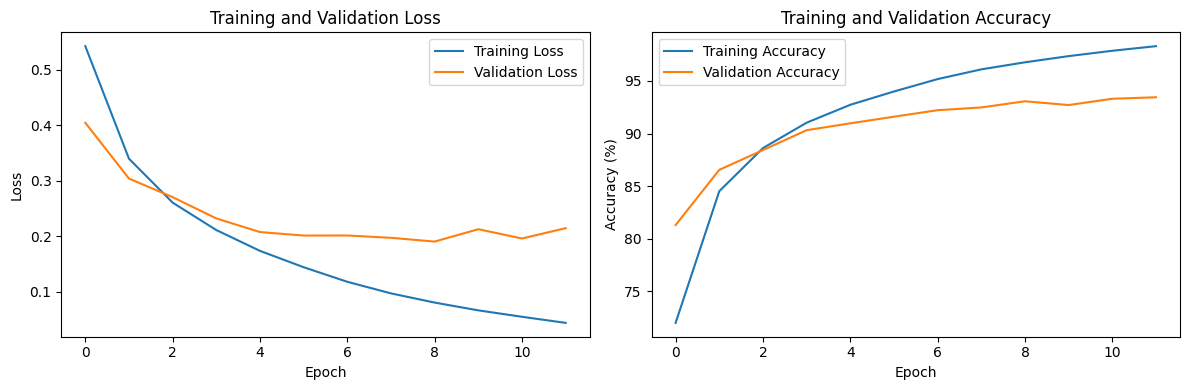

In [ ]:
# Train the model
train_model(eff, train_loader, val_loader, criterion, optimizer_eff, num_epochs=25)

### Evaluations EfficientNet

In [ ]:
# Evaluate the model
y_pred_eff, y_true_eff = evaluate_test(eff, test_loader)

Test Accuracy: 93.59%



Classification Report:
              precision    recall  f1-score   support

         MSI       0.95      0.92      0.93      4600
         MSS       0.92      0.95      0.94      4600

    accuracy                           0.94      9200
   macro avg       0.94      0.94      0.94      9200
weighted avg       0.94      0.94      0.94      9200



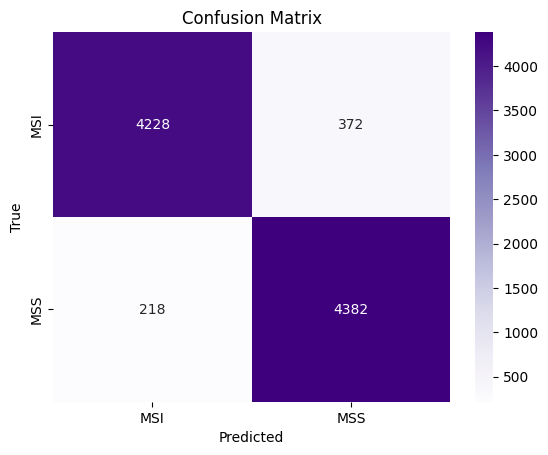

In [ ]:
# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true_eff, y_pred_eff, target_names= test_data.classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_eff, y_pred_eff)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels= test_data.classes, yticklabels= test_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print (f'PPV= {4228/(4228 + 218)}')

PPV= 0.9509671614934773


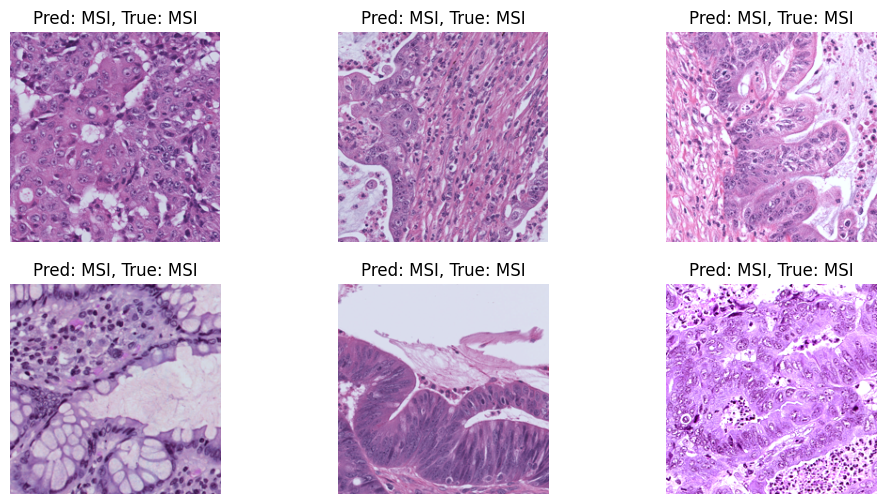

In [ ]:
# Visualize predictions
visualize_predictions(eff, test_loader)

Test Accuracy: 93.66%


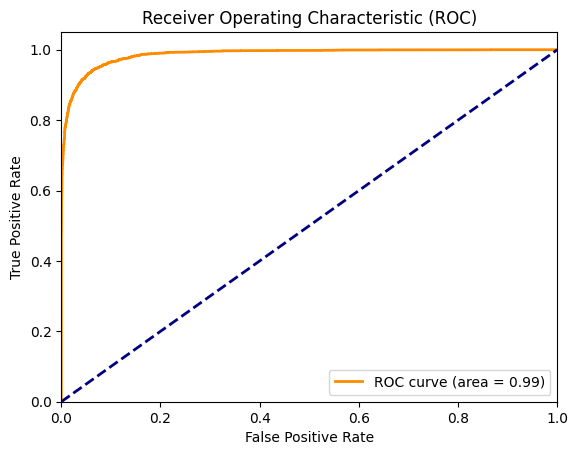

In [ ]:
evaluate_model_and_plot_roc(eff, test_loader)

In [ ]:
count_parameters(eff)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 0.38 Giga FLOPs
Total Number of Parameters: 4.01 million
Trainable Number of Parameters: 4.01 million


In [ ]:
epoch_eff = 12
loss_eff = 0.0441

In [ ]:
save_checkpoint(eff, optimizer_eff, epoch_eff, loss_eff, path="checkpoint_eff_2.pth")

Checkpoint saved to: checkpoint_eff_2.pth


### GradCAM EfficientNet

In [ ]:
# Access the correct layer for Grad-CAM (conv_pwl in the last block)
last_block = eff.blocks[-1]  # This is a Sequential module

In [ ]:
# Check for Conv2d layers in all submodules of the last_block
for name, layer in last_block.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        print(name, layer)

0.conv_pw Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
0.conv_dw Conv2d(1152, 1152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1152, bias=False)
0.se.conv_reduce Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
0.se.conv_expand Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
0.conv_pwl Conv2d(1152, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
target_layer = last_block[0].conv_pwl

In [ ]:
# Initialize GradCAM with the identified layer
gradcam_eff = GradCAM(eff, target_layer)

In [ ]:
image_list = ['data/test/MSI/blk-TCTTFAFCPHDK-TCGA-QG-A5Z2-01Z-00-DX1.png',
              'data/test/MSI/blk-TGGWDGHQHWGS-TCGA-QG-A5Z2-01Z-00-DX2.png',
              'data/test/MSI/blk-THSPPPPFNKIL-TCGA-G4-6304-01Z-00-DX1.png',
              'data/test/MSS/blk-YGFVGPWSQWEI-TCGA-AZ-4682-01Z-00-DX1.png',
              'data/test/MSS/blk-YGKVAIKLCEGH-TCGA-4N-A93T-01Z-00-DX1.png',
              'data/test/MSS/blk-YIKMYYLPHAFQ-TCGA-AF-A56L-01Z-00-DX1.png']

C:\Users\olubo\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


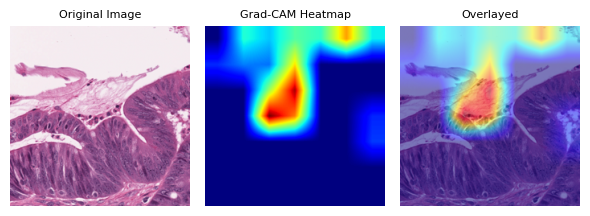

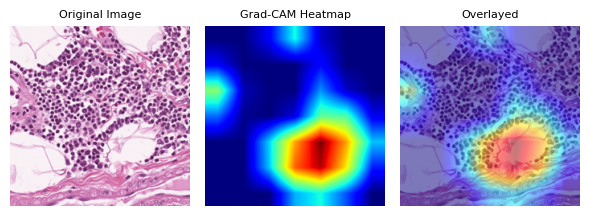

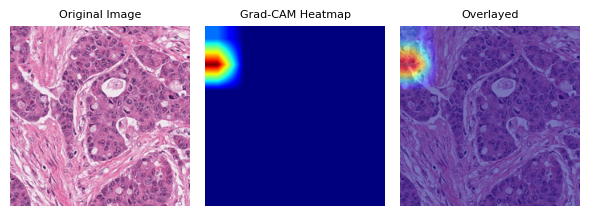

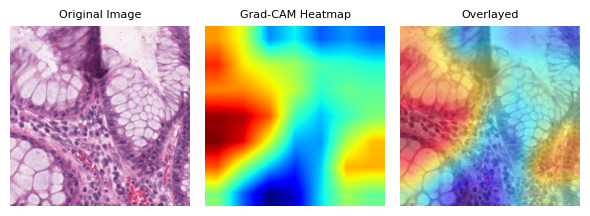

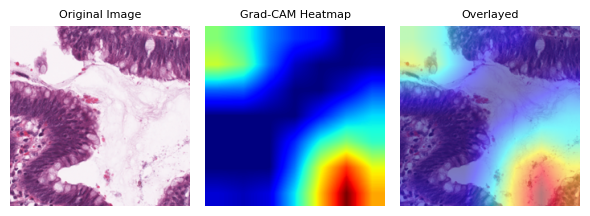

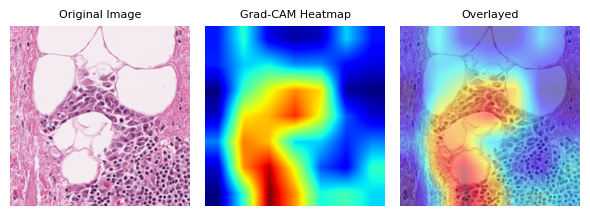

In [ ]:
for image_path in image_list:
    visualize_gradcam(eff, gradcam_eff, image_path, transform)

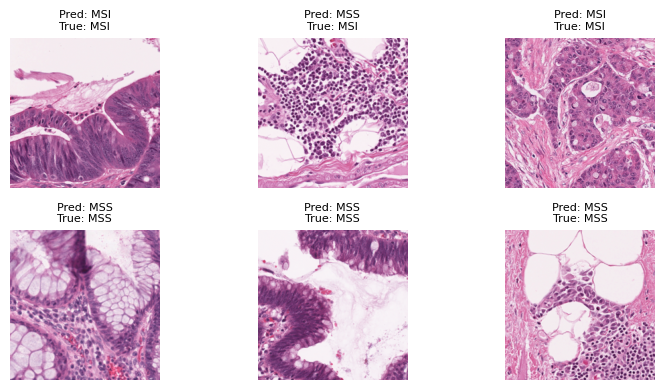

In [ ]:
visualize_list(eff, image_list, transform, num_images=6)

In [ ]:
torch.cuda.empty_cache()